## **Exploratory analysis and prediction on the "TMDB 5000 Movie Dataset" dataset**

***Authors: Bava Flavio 4836427 , Ciarlo Francesco 4640121, Oldrini Edoardo 4055097***

**Abstract**

The following data analysis aims to study an approach for the production of a movie.<br><br>
This file is divided like so:
* Dataset checking and preparation
* Initial exploration of the dataset
* Raising hypotheses and subsequent verification
* Proposal for a predictive regression based on previous observations

**Importing libraries and datasets**

In [1]:

import matplotlib.pyplot as plt # this is used for the plot the graph 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # used for plot interactive graph.
import numpy as np 
import plotly.offline as py
import json
from plotnine import ggplot,aes,facet_grid,labs,geom_col,theme_xkcd
py.init_notebook_mode(connected=True) #TODO ????
import plotly.graph_objs as go
import warnings #TODO ????
warnings.filterwarnings('ignore') #TODO ????
from pylab import rcParams #TODO ????
from ast import literal_eval

In [2]:
Movies = pd.read_csv('tmdb_5000_movies.csv')

### **Exploratory analysis of the dataset**

Moving all columns with Json data into list

In [3]:
def get_name(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        return names
    return []

def get_ISO(x):
    if isinstance(x, list):
        isos = [i['iso_3166_1'] for i in x]
        return isos
    return []

Funzioni per passare da json a liste dei dati utili

In [4]:
feat_to_manage = ['genres','keywords','production_countries','production_companies'] 

In [5]:
for f in feat_to_manage:
    Movies[f] = Movies[f].apply(literal_eval)

In [6]:
#Turn genres into list
Movies['genres'] = Movies['genres'].apply(get_name)
#Turn prod_countries into list
Movies['production_countries'] = Movies['production_countries'].apply(get_ISO)
#Turn prod_companies into list
Movies['production_companies'] = Movies['production_companies'].apply(get_name)
#Turn keywords into list
Movies['keywords'] = Movies['keywords'].apply(get_name)

Movies.head(1)

print("Generi hanno tipo ", type(Movies['genres'][0]))
print("Paesi produzione hanno tipo ", type(Movies['production_countries'][0]))


Generi hanno tipo  <class 'list'>
Paesi produzione hanno tipo  <class 'list'>


Check dataset dimension and an overview of the table itself

In [7]:
print("Dataset has {} rows and {} columns".format(Movies.shape[0],Movies.shape[1]))

Dataset has 4803 rows and 20 columns


Droppiamo colonne inutili

In [8]:
Movies.drop(['homepage','spoken_languages','original_title'],inplace=True,axis='columns')
Movies.shape

(4803, 17)

1. Controlliamo chei tipi siano giusti

In [9]:
Movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   overview              4800 non-null   object 
 6   popularity            4803 non-null   float64
 7   production_companies  4803 non-null   object 
 8   production_countries  4803 non-null   object 
 9   release_date          4802 non-null   object 
 10  revenue               4803 non-null   int64  
 11  runtime               4801 non-null   float64
 12  status                4803 non-null   object 
 13  tagline               3959 non-null   object 
 14  title                 4803 non-null   object 
 15  vote_average         

I tipi sono coerenti

2. Controlliamo se ci sono dati mancanti

In [10]:
print(Movies.isnull().sum())

budget                    0
genres                    0
id                        0
keywords                  0
original_language         0
overview                  3
popularity                0
production_companies      0
production_countries      0
release_date              1
revenue                   0
runtime                   2
status                    0
tagline                 844
title                     0
vote_average              0
vote_count                0
dtype: int64


ci sono alcuni valori nulli ma in colonne che potrebbero non essere significative

3. Controlliamo che i budget abbiano valori sensati

In [11]:
#TODO possibile predizione buget come studio
print(Movies['budget'].describe())

count    4.803000e+03
mean     2.904504e+07
std      4.072239e+07
min      0.000000e+00
25%      7.900000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64


Il valore minimo è 0, abbiamo quindi il dubbbio che ci siano budget con valori insiensati, per conoscenza del dominio applciativo decidiamo di porre il limite inferiore di 10k per il budget, verifichiamo quanti film sono sotto a questo valore.

Ci sono 1400 film con un valore di budget che non sembra avere senso, per evitare di eliminare tutti i dati relativi a questo film decidiamo di "segnarli" ponendo il budget ad un valore simbolico di -1 questi dati in modo da non prenderli in considerazione nelle statistiche ma non perdere altri dati interesanti.

In [12]:
#Movies[Movies['budget'] <= 10000]['budget'] = np.nan
for row in Movies.index:
    if Movies.loc[row,'budget'] < 10000 and (Movies.loc[row, 'status']=='Released'):
        Movies.loc[row,'budget'] = np.nan
print(Movies[Movies['budget'] == np.nan].shape)

(0, 17)


In [13]:
print(Movies[Movies['budget']<10000]['id'].count())
#Movies.tail()

5


4. Controlliamo che i revenue abbiano valori sensati

In [14]:
#TODO possibile predizione buget come studio
#Movies.tail()
print(Movies['revenue'].describe())

count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64


molti film hanno revenue nullo, che siano film ancora non usciti?

In [15]:
print('Movies with 0$ revenues: ',Movies[Movies['revenue'] == 0].shape[0])
print('Movies not yet released', Movies[(Movies['revenue'] == 0) & (Movies['status']!= 'Released')].shape[0])

Movies with 0$ revenues:  1427
Movies not yet released 7


Su 1427 film che hanno revenue = 0 solo 7 sono ancora in fase di produzione, quindi 1427 film hanno un valore di revenue errato che procediamo a segnare, come visto precedentemente, con un valore simbolico di -1

In [16]:
for row in Movies.index:
    if (Movies.loc[row, 'revenue'] == 0) and (Movies.loc[row, 'status']=='Released'):
        Movies.loc[row, 'revenue'] = -1

print('Movies without revenue infos: ',Movies[Movies['revenue'] == -1].shape[0])


Movies without revenue infos:  1420


3. Ulteriori aggiustamenti

Aggiungiamo due colonne legate al budget, una misura i ricavi sulla percentuale rispetto al budget, l'altra divide i film in 3 categorie, low budget, normali e blockbuster


1) Ricavi rispetto al budget


In [17]:
def calculate_profit_perc(x):
    if (x.revenue>0) and (x.budget>0):
        return ((x.revenue-x.budget)/x.budget)*100
    #senza else mette i nan, altrimenti possiamo metterlo e ritornare -1

In [18]:
#Movies = Movies.assign(profit_perc = lambda x: (((x.revenue-x.budget)/x.budget)*100) if ((x.revenue>0) and (x.budget>0)) else -1)
#print(Movies[Movies['budget'].isnull()])
Movies = Movies.assign(profit_perc = lambda x: x.budget)
for row in Movies.index:
    Movies.loc[row,'profit_perc'] =  calculate_profit_perc(Movies.loc[row])



2. Classificazioni film in low, med, high budget

usiamo describe per capire come impostare gli scaglioni

In [19]:
Movies[Movies['budget']>0]['budget'].describe()

count    3.731000e+03
mean     3.739032e+07
std      4.269420e+07
min      1.000000e+04
25%      8.850000e+06
50%      2.400000e+07
75%      5.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

Low budget = 25% con budget più bassi<br>
High budget = 25% con budget più alti<br>
Medio = il restante 50%

In [20]:
def budget_range(x):
    if x <= 0: #x==NaN
        return "no budget info"
    if x < 7.900000e+05:
        return "low"
    elif x >= 7.900000e+05 and x < 4.000000e+07:
        return "medium"
    else:
        return "high"

aggiungiamo una colonna che contiene l'etichetta relativa al budget

In [21]:
Movies = Movies.assign(budget_class = lambda x: str(x.budget))
for row in Movies.index:
    Movies.loc[row,'budget_class'] =  budget_range(Movies.loc[row,'budget'])


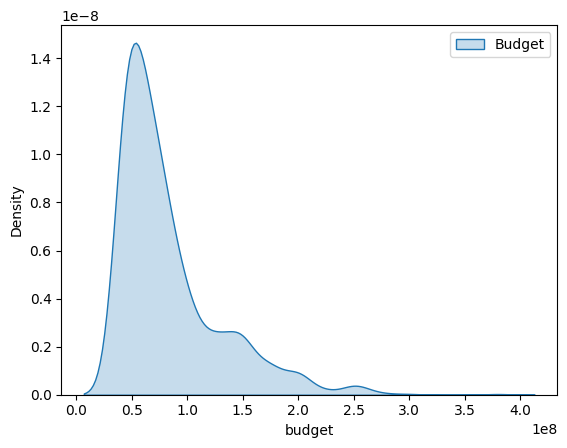

In [22]:
#TODO: perchè prendiamo solo i budget>10^7 e non tutti i non negativi?
#sns.kdeplot(data=Movies[Movies['budget'] >0], x='budget', shade = True)
sns.kdeplot(data=Movies[Movies['budget'] >= 4.000000e+07], x='budget', shade = True)
plt.legend(['Budget'])
plt.show()


Riteniamo importante che la media dei voti sia pesata con il numero di voti che la generano, per fare questo usiamo una formula consigliata dal celebre sito IMBD e togliamo le due colonne average e count per unirle in una che le metta insieme

In [23]:
#TODO: potremmo anche fare questo lavoro sul dataset di partenza aggiungendo una colonna, metà avranno nan
C= Movies['vote_average'].mean()
C
m= Movies['vote_count'].quantile(0.5)

for i in Movies.index:
    if Movies.loc[i,'vote_count'] <= m:
        Movies.loc[i,'vote_count'] = np.nan
    else:
        pass

    
q_movies = Movies[['id','vote_count','vote_average']]


In [24]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [25]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies.drop(['vote_average','vote_count'],inplace=True,axis='columns')
#Merge dei dataframe,ora Movies ha anche la colonna Score",
Movies = pd.merge(Movies,q_movies,on='id',how='inner')
Movies.shape
   

(4803, 20)

Abbiamo eliminato metà dei film, quelli con troppi pochi voti per poter essere presi in considerazione per quanto riguarda il voto ricevuto.

Breve sguardo agli attributi quantitativi

In [26]:
Movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,profit_perc,score
count,3.736000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,2401.000000,3.214000e+03,2401.000000
mean,3.734028e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,1306.258642,1.009349e+03,6.402426
std,4.268752e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1511.970047,2.399545e+04,0.629714
min,0.000000e+00,5.000000,0.000000,-1.000000e+00,0.000000,0.000000,236.000000,-9.999995e+01,3.976270
25%,8.500000e+06,9014.500000,4.668070,-1.000000e+00,94.000000,5.600000,414.000000,2.586393e+00,5.958196
50%,2.300000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,737.000000,1.300444e+02,6.361583
75%,5.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,1526.000000,3.416902e+02,6.804813
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,1.288939e+06,8.432957


### **Cominciamo a fare qualche ipotesi**

**1. Dati qualitativi**

usiamo una funziona di libreria per portare genri, keyword, paesi di produzione e compagnie di produzione in un formato più semplice da gestire

******************************************************************************************************************************************
******************************************************************************************************************************************

## Dati qualitativi ##

Proviamo a definire delle funzioni per verificare la distribuzione di voti e soldoni fatti in base ai dati qualitativi

In [27]:
#TODO: perchè è commentata? Non serve più?
#def get_name(x):
 #   if isinstance(x, list):
  #      names = [i['name'] for i in x]
   #     return names
    #return []

### Primo qualitativo: generi ###

1. definiamo funzione che dato un genere calcola la media dei profitti dei film che lo contengono

In [28]:
def genre_average_profits(genre):
    sum = 0
    count = 0
    for row in Movies.index:
        if (genre in Movies.loc[row, 'genres']) and (Movies.loc[row,'profit_perc'] > 0):
            sum += Movies.loc[row, 'profit_perc']
            count+=1
    return count

#Movies['profit_perc'] = Movies.apply(lambda row: genre_average_profits(row['genres']), axis=1)

2. estraiamo dal dataset la lista dei generi presenti

In [29]:
genres=[]
for row in Movies.index:
    _gen = Movies.loc[row,'genres']
    for g in _gen:
        if g not in genres:
            genres.append(g)

print("I generi presenti nel dataframe sono:")
for el in genres:
    print('\t',el)

I generi presenti nel dataframe sono:
	 Action
	 Adventure
	 Fantasy
	 Science Fiction
	 Crime
	 Drama
	 Thriller
	 Animation
	 Family
	 Western
	 Comedy
	 Romance
	 Horror
	 Mystery
	 History
	 War
	 Music
	 Documentary
	 Foreign
	 TV Movie


3. calcoliamo e salviamo il profitto medio di ogni genere

In [30]:
profits=[]
for g in genres:
    profits.append(genre_average_profits(g))
            
print("Profitto associato ad ogni genere:")
for i in range(0,len(genres)):
    print('\t',genres[i], " has a mean profit of ", profits[i])

Profitto associato ad ogni genere:
	 Action  has a mean profit of  693
	 Adventure  has a mean profit of  524
	 Fantasy  has a mean profit of  274
	 Science Fiction  has a mean profit of  329
	 Crime  has a mean profit of  387
	 Drama  has a mean profit of  1013
	 Thriller  has a mean profit of  694
	 Animation  has a mean profit of  150
	 Family  has a mean profit of  297
	 Western  has a mean profit of  40
	 Comedy  has a mean profit of  843
	 Romance  has a mean profit of  434
	 Horror  has a mean profit of  270
	 Mystery  has a mean profit of  191
	 History  has a mean profit of  102
	 War  has a mean profit of  85
	 Music  has a mean profit of  84
	 Documentary  has a mean profit of  26
	 Foreign  has a mean profit of  0
	 TV Movie  has a mean profit of  0


Due generi hanno una media pari a 0, appaiano quindi solo nei film per cui non abbiamo info su budget e/o revenue, li eliminiamo quindi dalla lista dei generi

In [31]:
genres.remove(genres[19])
genres.remove(genres[18])
profits.remove(profits[19])
profits.remove(profits[18])

3. Di seguito possiamo vedere come sono i profitti in base ai diversi generi dei film

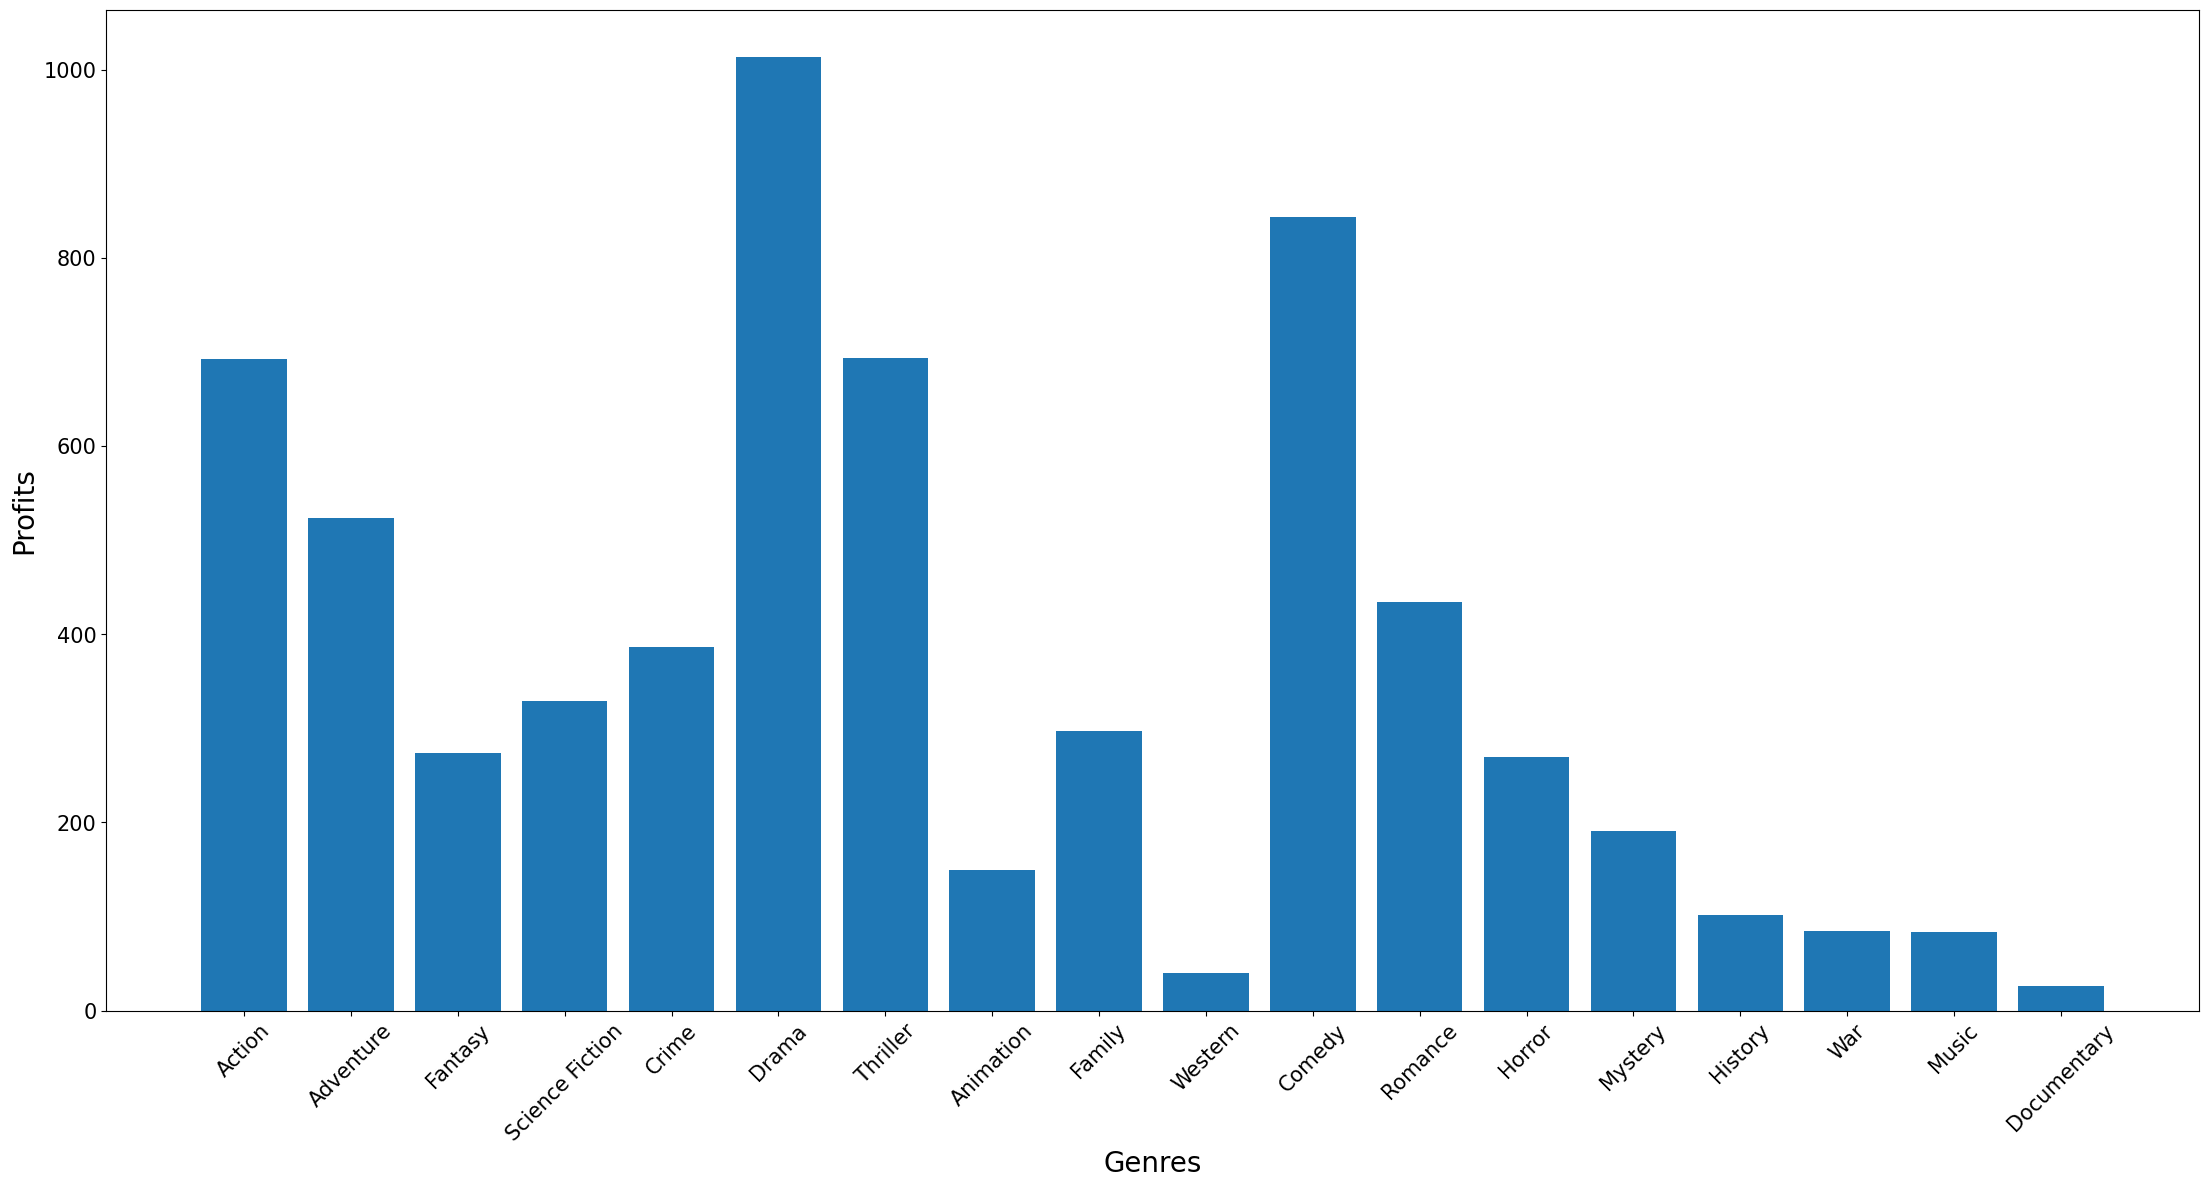

In [32]:
#TODO: riusciamo a farli in ordine decrescente sul grafico?
fig, ax = plt.subplots()
ax.bar(genres,profits)
fig.set_figwidth(27)
fig.set_figheight(13)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Genres", fontsize=20)
plt.ylabel("Profits", fontsize=20)
plt.show()

Per ottimizzare le funzioni di libreria sostituiamo ai valori dei profitti associati ai film con dati insufficienti a calcolarli il valore nan

In [33]:
#TODO: si può mica fare da subito?
for row in Movies.index:
    if (Movies.loc[row, 'profit_perc'] <= 0) and (Movies.loc[row, 'status']=='Released'):
        Movies.loc[row, 'profit_perc'] = np.nan

### Secondo qualitativo: keywords ###

1. importiamo i profitti e le keywords associate solo a film su cui non abbiamo dati relativi ai profitti, precedentemente calcolate con una funzione pesante

In [ ]:
#key_profits = pd.read_csv('key_profits.csv')['0']
#bad_key_df = pd.read_csv('bad_key.csv')
#bad_key=bad_key_df['0']

2. estraiamo dal dataset la lista delle presenti

In [ ]:
keywords=[]
for row in Movies.index:
    _key = Movies.loc[row,'keywords']
    for k in _key:
        if g not in keywords:
            keywords.append(k)
print(len(keywords))

3. definiamo una funzione che data una keyword ne calcola la media dei profitti associati

In [ ]:
def keyword_average_profit(keywords):
    sum = 0
    count = 0
    for row in Movies.index:
        if (keywords in Movies.loc[row, 'keywords'] and Movies.loc[row, 'profit_perc'] >= 0):
            sum += Movies.loc[row, 'profit_perc']
            count+=1
    if count != 0:
        return sum/count
    else:
        return -1

4. ora per ogni keyword calcoliamo il profitto e salviamo quali keywords non hanno dati su budget o revenue

In [ ]:
#funzione pesantissima con hash
set_key = set(keywords)
key_profits={} #declared as hashmap
bad_keys=[]
for k in set_key:
    q = keyword_average_profit(k)
    if q != -1:
        key_profits[str(k)]=q
    else:
        bad_keys.append(k)

5. A questo punto castiamo l'array di tutte le keywords e di quelle da scartare in set, così da eleminare ogni duplicato e poter effettuare una differenza:

In [ ]:
bad_key_set = set(bad_keys)
set_key_cleaned = set_key - bad_key_set

print("Numero di keywords:\t",len(set_key))
print("Numero di keywords da scartare\t",len(bad_key_set))
print("Numero di keywords da analizzare:\t",len(set_key_cleaned))
print("Numero di profitti per le keywords calcolati\t",len(key_profits))

#pd.DataFrame(key_profits).to_csv("key_profits.csv")

In [ ]:
sorted_key_hash = sorted(key_profits.items(), key=lambda x: x[1])
print(sorted_key_hash)

6. visto il grande numero di keywords presenti nel dataset ci concentriamo su quelle più presenti

In [ ]:
from collections import Counter #per prendere le più presenti

best = 100 #numero di keywords da studiare 
_most_common_keys = Counter(keywords).most_common(best)
most_common_keys = []
for i in range(0,best-1):
    #print(most_common_keys[0])
    most_common_keys.append(_most_common_keys[i][0])
print(most_common_keys)


In [ ]:
#associamo alle key più frequenti selezionate sopra il rispettivo profitto
most_common_keys_prof = []
for el in most_common_keys:
    most_common_keys_prof.append(key_profits[str(el)])

7. stampiamo ora un istogramma che associa alle keywords più comuni il rispettivo profitto

In [ ]:
fig, ax = plt.subplots()
ax.bar(most_common_keys,most_common_keys_prof)
fig.set_figwidth(27)
fig.set_figheight(13)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("key", fontsize=20)
plt.ylabel("Profits", fontsize=20)
plt.show()

visto che il grafico così è poco leggibile rappresentiamo i risutlati in un altro modo

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords")
from nltk.tokenize import word_tokenize


plt.subplots(figsize=(12,12))
stop_words=set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

Movies['keywords'].dropna(inplace=True)
Movies['keywords'] = Movies['keywords'].astype(str)
words=Movies['keywords'].apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=4000,stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

si può fare altro, ma ora ci spostiamo su altro...

### qualitiativo 3: paesi di produzione ###

1. Troviamo e salviamo tutti i paesi di produzione del dataframe

In [ ]:
countries=[]
for row in Movies.index:
    _countries = Movies.loc[row,'production_countries']
    for k in _countries:
        if k not in countries:
            countries.append(k)

print(len(countries))
print(countries)

2. definiamo una funzione che dato un pease di produzine calcoli il profitto dei film girati li

In [ ]:
def country_average_profit(country):
    sum = 0
    count = 0
    for row in Movies.index:
        if (country in Movies.loc[row, 'production_countries'] and Movies.loc[row, 'profit_perc'] >= 0):
            sum += Movies.loc[row, 'profit_perc']
            count+=1
    if count != 0:
        return sum/count
    else:
        return -1

3. creiamo una hashmap in cui associamo ad ogni paese di produzione il relativo profitto, mettendo in bad_countries i paesi i cui film non hanno info sufficienti per il calcolo dei profitti

In [ ]:
country_profits={} #declared as hashmap
bad_countries=[] #TODO: si può fare subito set o serve array?
for c in countries:
    q = country_average_profit(c)
    if q != -1:
        country_profits[str(c)]=q
    else:
        bad_countries.append(c)

4. rimuoviamo i paesi di produzione dei cui film non abbiamo info

In [ ]:
set_countries = set(countries)
bad_countries_set = set(bad_countries)
set_countries_cleaned = set_countries - bad_countries_set


print("Numero di paesi di produzione totali:\t\t",len(set_countries))
print("Numero di paesi di produzione da scartare:\t",len(bad_countries_set))
print("Numero di paesi di produzione da analizzare:\t",len(set_countries_cleaned))
print("Numero di profit per paese da analizzare:\t",len(country_profits))


5. mettiamo in un array, nel giusto ordine, i profitti da plottare

In [ ]:
country_profits_plot = []
for el in set_countries_cleaned:
    country_profits_plot.append(country_profits[str(el)])

In [ ]:
fig, ax = plt.subplots()
ax.bar(list(set_countries_cleaned),list(country_profits_plot))
fig.set_figwidth(20)
fig.set_figheight(13)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("key", fontsize=20)
plt.ylabel("Profits", fontsize=20)
plt.show()

6. Notiamo un valore molto alto per la Jamaica, ci stupisce. Controlliamo quanti e quali film ci sono

In [ ]:
for row in Movies.index:
    if 'JM' in Movies.loc[row,'production_countries']:
        print(Movies.loc[row,'profit_perc'])

solo due, dobbiamo fare lo stesso lavoro fatto per le keywords sulla frequenza

In [ ]:
#TODO: fare country con frequenza

******************************************************************************************************************************************
******************************************************************************************************************************************

## Logaritmi, decidere dove va fatto!!##

purtroppo la distrubuzione dei profitti è pessima e potrebbe portare a delle rpoblematiche future, per migliorarla possiamo applicare la funzione logaritmica

In [ ]:
#TODO: separare in due fasi, prima stampiamo la distribuzione, poi diciamo che fa cagare e dopo applichiamo log e diciamo che va meglio
Movies['log_perc'] = np.log(Movies['profit_perc'])
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1,2,1)
plt.hist(Movies['profit_perc'])
plt.title('Distribution of Profits%')
plt.subplot(1,2,2)
plt.hist(Movies['log_perc'])
plt.title('Log Distribution of Profits%')
plt.show()



Il grafico sembra dire che il log ha funzionato, controliamo la skewness

In [ ]:
print('Skewness : %f '% Movies['profit_perc'].skew())
print('Applied Log Skewness : %f '% Movies['log_perc'].skew())


i risutlati confermano quanto suggerito dal grafico, analizziamo ancora come la distribuzione sia cambiata e quanto effettivamente sia migliorata

In [ ]:
sns.distplot(Movies['profit_perc'])
plt.figure(figsize=(16,6))
plt.legend(['Profit'])
plt.title('Profit Perc')
sns.distplot(Movies['log_perc'])
plt.legend(['Profit'])
plt.title('Log Profit Perc')
plt.show()

miglioratissima....ossia studiamo bene cosa vogliono dire sti grafici

******************************************************************************************************************************************
******************************************************************************************************************************************

## Dataset unito a crew ##

**Iniziamo a lavorare con il dataset contenente il cast e il direttore**

In [ ]:
Movies.columns

In [34]:
cast = pd.read_csv("tmdb_5000_credits.csv")

In [35]:
feat_to_manage = ['cast','crew']
for f in feat_to_manage:
    cast[f] = cast[f].apply(literal_eval)

#Two functions that convert directors and actors from json to list-str
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_actors(x): #TODO:si può usare senza fare modifiche get_name?
    if isinstance(x, list):
        names = [i['name'] for i in x]
        
        return names
    return []

In [36]:
#Create two new column correctly formatted
cast['director'] = cast['crew'].apply(get_director)
cast['actors'] = cast['cast'].apply(get_actors)

In [37]:
#Drop old columns
cast.drop('cast',inplace=True,axis=1)
cast.drop('crew',inplace=True,axis=1)
cast.drop('title',inplace=True,axis=1)



In [38]:
#rename Movie_id to id, preparing for the merge
cast = cast.rename(columns={'movie_id': 'id'})

#Merge two dataframe Movies,cast
full_df = pd.merge(Movies,cast,on="id",how="inner")
#full_df.to_csv("updated.csv")

Let's see how many times actors appears in different films

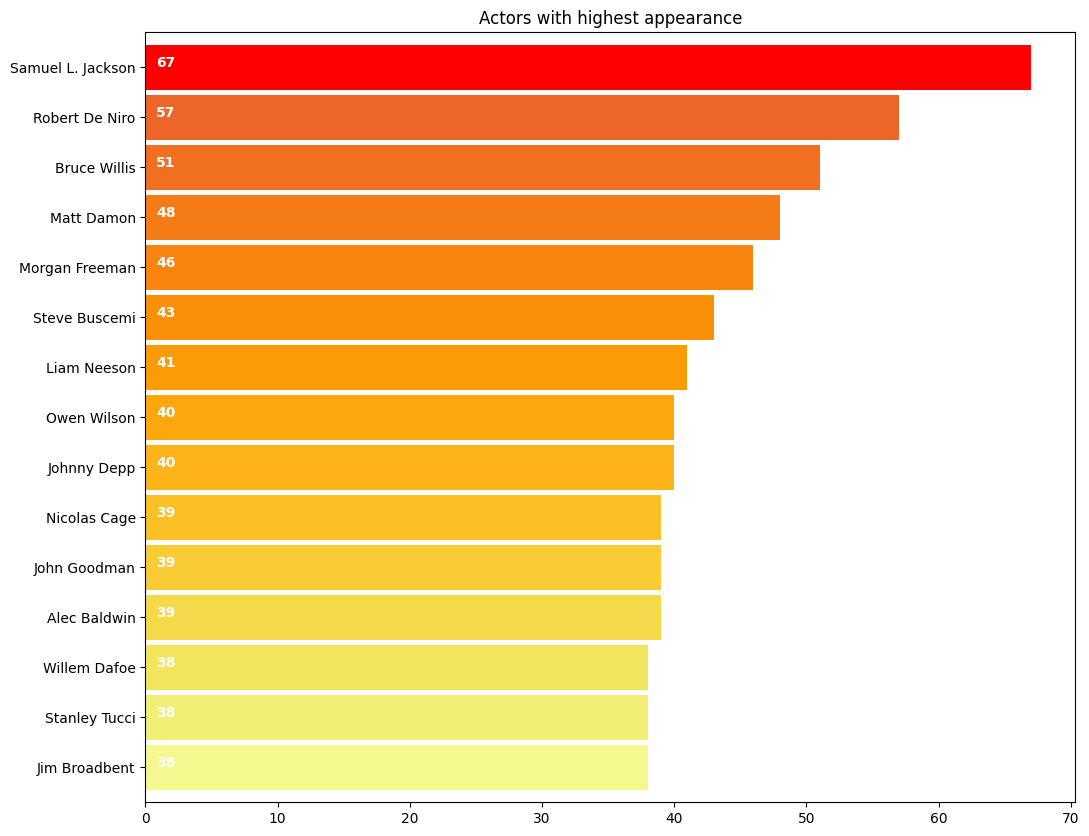

In [39]:

actors=[]


for i in full_df['actors']:
    actors.extend(i)

actors = list(filter(None, actors))


plt.subplots(figsize=(12,10))
ax=pd.Series(actors).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(pd.Series(actors).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')

plt.title('Actors with highest appearance')
ax.patches[14].set_facecolor('r')
plt.show()


### Registi ##

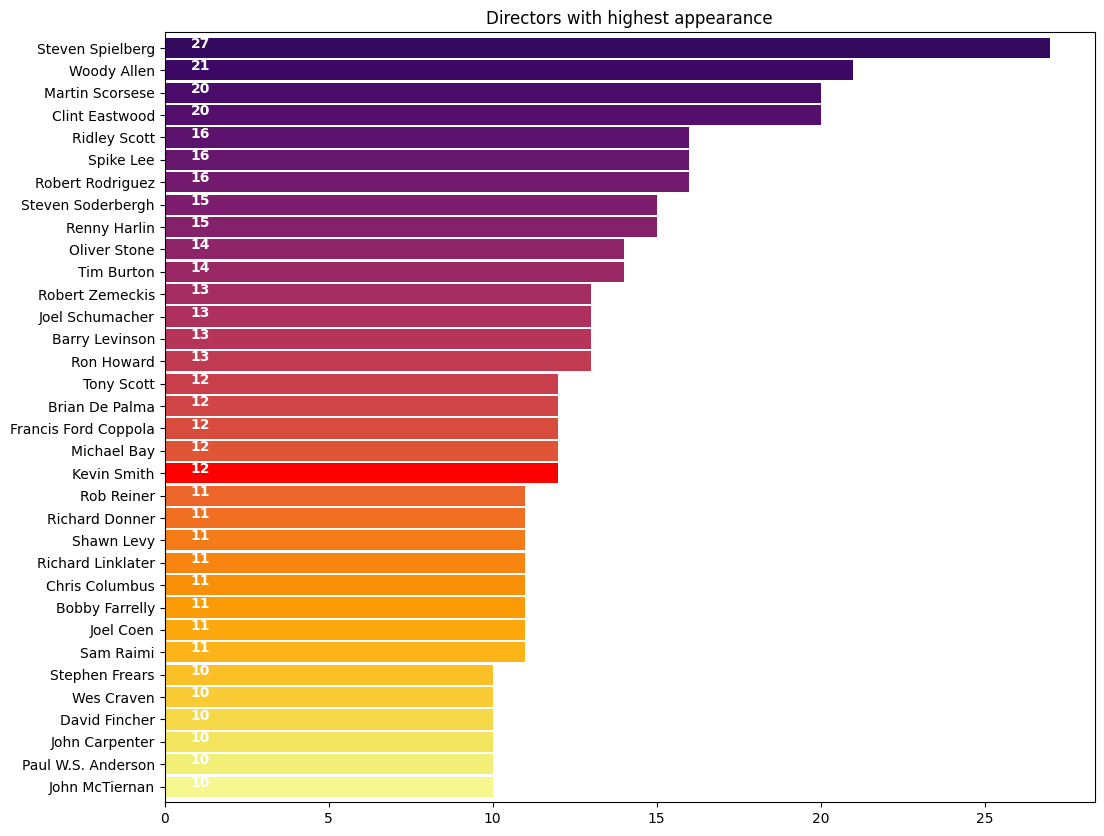

In [40]:
directors=[]


for i in full_df['director']:
    directors.append(i)

directors = list(filter(None, directors))


plt.subplots(figsize=(12,10))
ax=pd.Series(directors).value_counts()[:34].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(pd.Series(directors).value_counts()[:34].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')

plt.title('Directors with highest appearance')
ax.patches[14].set_facecolor('r')
plt.show()

Calcoliamo Score medio per i registi più presenti(>= 10)

In [41]:
#Filter the directors with made films >= 10,then calculate the mean scores
#Dovrebbe fare lo stesso lavoro di score_for_director applicato poi alla hashmap, quindi ho rimosso entrambe

director_group = full_df.groupby('director').filter(lambda x : len(x) >= 10)
mean_scores = director_group.groupby('director')['score'].mean().sort_values(ascending=False).reset_index(name="score")

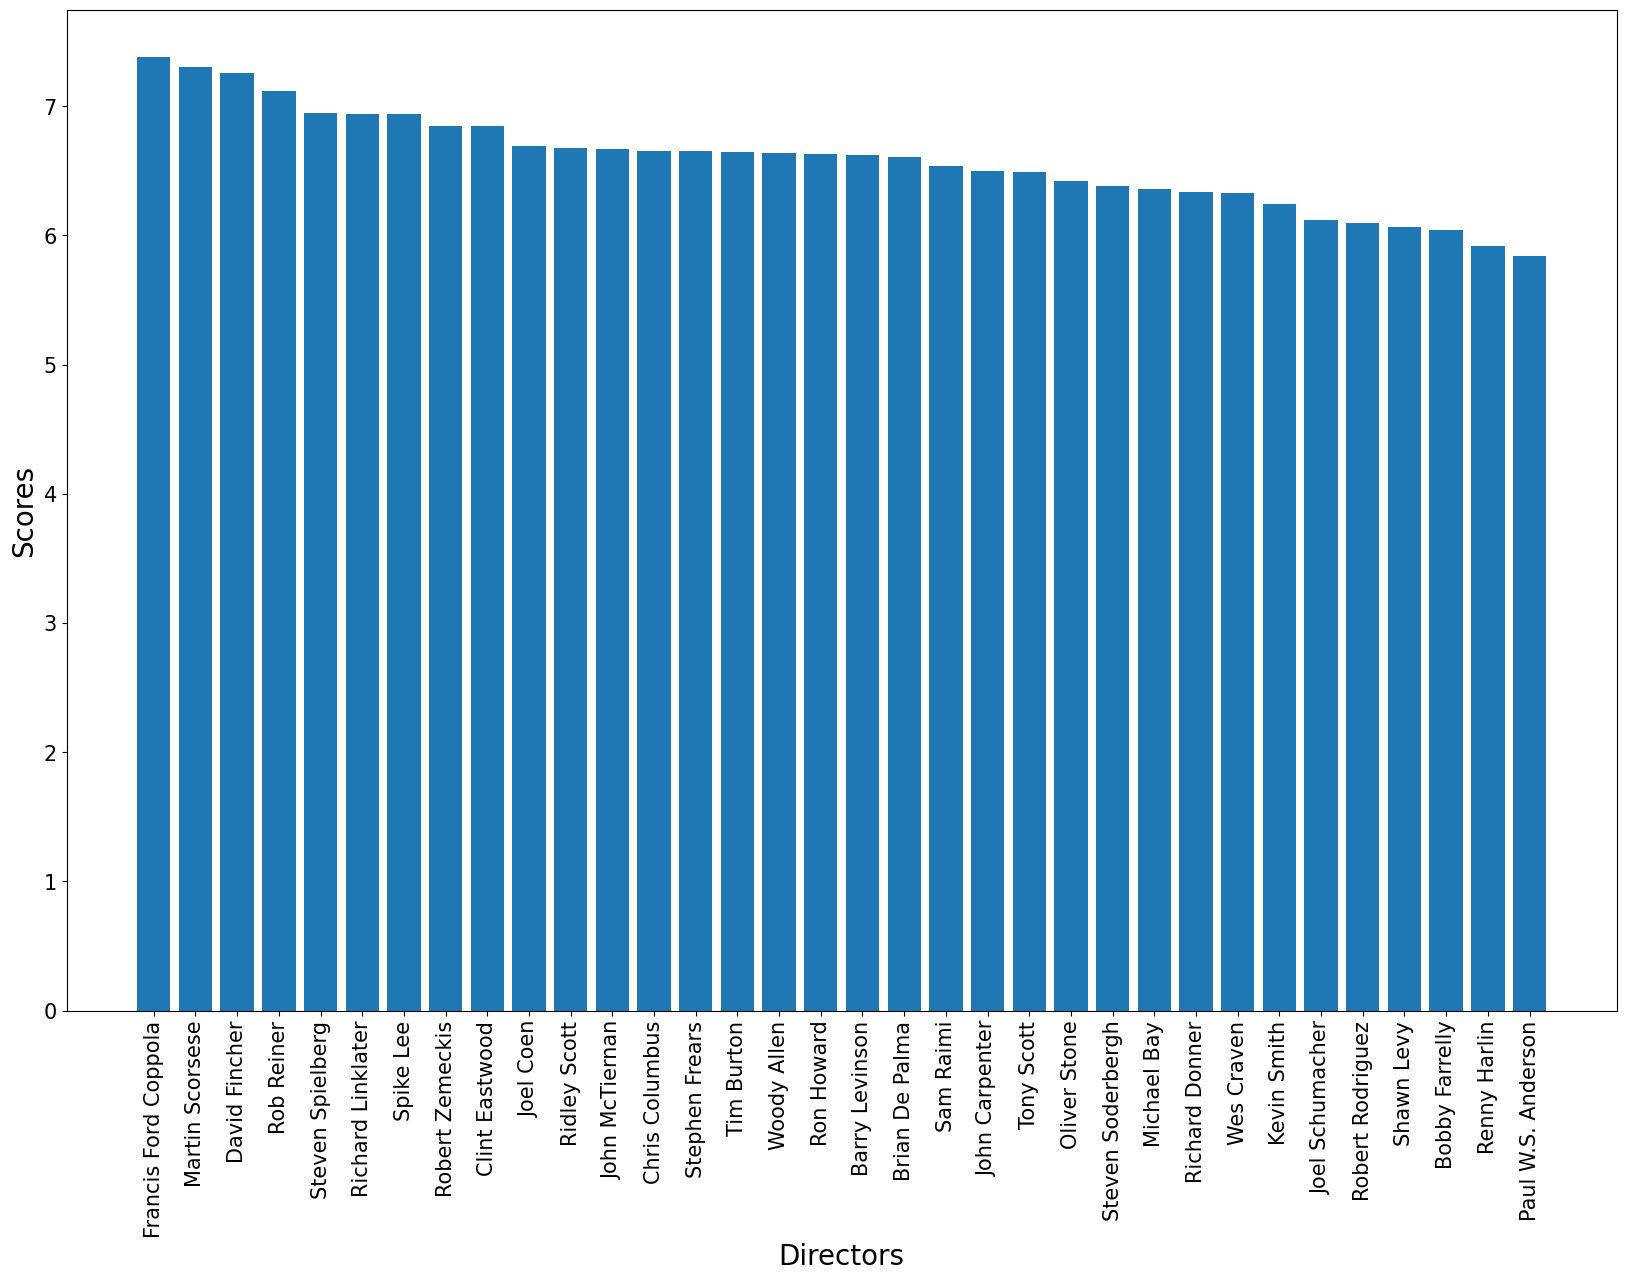

In [42]:
fig, ax = plt.subplots()
ax.bar(mean_scores['director'],mean_scores['score'])
fig.set_figwidth(20)
fig.set_figheight(13)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Directors", fontsize=20)
plt.ylabel("Scores", fontsize=20)
plt.show()

cerchiamo non rating ma score: Fatto ^

******************************************************************************************************************************************
******************************************************************************************************************************************

## Dati quantitativi ##

prendiamo solo il primo valore dei quantitativi 


******************************************************************************************************************************************
******************************************************************************************************************************************

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
tfidf = TfidfVectorizer(stop_words="english")
full_df['overview'] = full_df['overview'].fillna('')
tfidf_matr = tfidf.fit_transform(full_df['overview'])
print(tfidf_matr)

  (0, 3545)	0.27493285363270825
  (0, 795)	0.2084074203878777
  (0, 14754)	0.26556705630591243
  (0, 13355)	0.25370721950251907
  (0, 7414)	0.2153609580612842
  (0, 19054)	0.23864791282019557
  (0, 12269)	0.1778447209530258
  (0, 19671)	0.24152597853522884
  (0, 13644)	0.29248619979162926
  (0, 12411)	0.27155366980600426
  (0, 5519)	0.27863433071832444
  (0, 11667)	0.2580267910376776
  (0, 13680)	0.3411386462681145
  (0, 3232)	0.19886014555883547
  (0, 225)	0.3055534742040413
  (1, 14969)	0.2764509091386784
  (1, 18376)	0.37466189442120984
  (1, 6188)	0.2743698871995736
  (1, 19418)	0.3060153616124342
  (1, 6016)	0.1966138874334538
  (1, 6069)	0.2948248727159851
  (1, 8674)	0.28094479737069844
  (1, 11025)	0.12158034118460531
  (1, 3843)	0.19195626583733216
  (1, 4854)	0.19967394354414503
  :	:
  (4802, 5841)	0.34247058916908363
  (4802, 4576)	0.15002600185636672
  (4802, 10126)	0.15121328276821536
  (4802, 16409)	0.17123529458454181
  (4802, 4816)	0.14223771161926407
  (4802, 1311)	0.

In [45]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarity = linear_kernel(tfidf_matr,tfidf_matr)
cosine_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

In [46]:
indices = pd.Series(full_df.index, index=full_df['title']).drop_duplicates()


In [47]:
print(full_df.query('title == "The Sting"')['overview'])

3526    Set in the 1930's this intricate caper deals w...
Name: overview, dtype: object


In [48]:
#Recommendation using cosine similarity
def get_recommendations(title, cosine_similarity=cosine_similarity):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_similarity[idx]))
    #print(sim_scores)
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #print(sim_scores)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return full_df['title'].iloc[movie_indices]


In [49]:
get_recommendations('The Godfather')

2731     The Godfather: Part II
1873                 Blood Ties
867     The Godfather: Part III
3727                 Easy Money
3623                       Made
3125                     Eulogy
3896                   Sinister
4506            The Maid's Room
3783                        Joe
2244      The Cold Light of Day
Name: title, dtype: object

**Recommendations using keyword,actors and director**

In [50]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer
# Compute the Cosine Similarity matrix based on the count_matrix
#from sklearn.metrics.pairwise import cosine_similarity

In [51]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [52]:
# Apply clean_data function to your features.
features = ['actors', 'keywords', 'director', 'genres']

for feature in features:
    full_df[feature] = full_df[feature].apply(clean_data)

In [53]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['actors']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
full_df['soup'] = full_df.apply(create_soup, axis=1)

In [54]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(full_df['soup'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of our main DataFrame and construct reverse mapping as before
full_df = full_df.reset_index()
indices = pd.Series(full_df.index, index=full_df['title'])

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
get_recommendations("The Godfather", cosine_sim2)

2731      The Godfather: Part II
867      The Godfather: Part III
4638    Amidst the Devil's Wings
4209            The Conversation
3293                 10th & Wolf
2255                   The Yards
1394               Donnie Brasco
3012               The Outsiders
4124          This Thing of Ours
1018             The Cotton Club
Name: title, dtype: object

droppare i nan
mettere in codifica hot il primo elemento delle colonne colonne:
    genere
    keyword
    director
    attori
    paese produ
    
_____________________________________________________________________
fare random forest che predice score/popul/rev/profit/altro usando le colonne fatte sopra
    

******************************************************************************************************************************************
******************************************************************************************************************************************

#TOTO: 

Toccherà caccaire nel cesso le hashmap

non è che tocca lavorare sui profitti ottenuti col logaritmo?

trovare modo per selezionare solo le country utili (con abbastanza film)

#mettere al posto dei -1 i NaN ma solo nella singola colonna non su tutta la riga
 
Qualitativi --> plot e contare, no correlazioni

sarebbe carino trovare sia le key con più profitto tra le più comuni sia le più comuni tra quelle con più profitto

#Eliminare valori inutile e insensati anche per revenue e "segnarli"
#Ricalcolare profit selezinando solo i film con valori sensati (!=-1)

Plottare profitto in base a:
    #genere
    keyword
    paese prod
    lingua originale (forse)

Plottare count dei generi in per ogni paese di prod (ad esempio giappone potrebbe avere più animazione della GB)

\************************************************

Dati quantitativi --> matematica:

Provare corr tra profitto(non revenue) e budget 
Provare corr tra profitto(non revenue) e score 
Provare corr tra profitto(non revenue) e popularity 

.
.
.
.

usiamo tutte le verità scoperte per fare varie predizioni
